# Step 8: Anamoly Detection using k-means

In [7]:
import os
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
import modin.pandas as pd
import gensim
import multiprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
from re import sub
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [13]:
import re

In [46]:
drug_disease_sentences = pd.read_csv('drug_disease_sentences_with_distance.csv')

In [47]:
def preprocess(text):
    text = str(text)

    #alpha numeric, punctuation remove kortesi
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)


    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if w == 'no' or w == 'not' or not w in stop_words]
    porter = PorterStemmer()
    stems = []
    for t in tokens:
        stems.append(porter.stem(t))

    clean_words = []	
    rx = re.compile(r'\D*\d')
    for s in stems:
        if rx.match(s):
            continue 
        clean_words.append(s)
    return clean_words

In [48]:
disease_list = drug_disease_sentences['disease'].tolist()
drug_list = drug_disease_sentences['drug'].tolist()
article_list_ = drug_disease_sentences['sentences'].tolist()

In [49]:
article_list = []
for article in tqdm(article_list_):
    article_list.append(preprocess(article))

100%|██████████████████████████████████████████████████████████| 4220/4220 [00:10<00:00, 408.67it/s]


In [50]:
def tagged_document(list_of_list_of_words):
   for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
data_for_training = list(tagged_document(article_list))

In [51]:
cores = multiprocessing.cpu_count()

In [52]:
model = gensim.models.doc2vec.Doc2Vec(data_for_training, vector_size=300, window=10, min_count=3, workers=cores, dm=1, alpha=0.025, min_alpha=0.001)
model.train(data_for_training, total_examples=model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [53]:
kmeans_model = KMeans(n_clusters=2, init='k-means++', max_iter=100) 
X = kmeans_model.fit(model.dv.vectors)
labels=kmeans_model.labels_.tolist()

In [54]:
import collections
min_element = min(labels,key=labels.count)
ii = 0
freq = 0
for l in labels:
	if l == min_element:
		freq+=1
		print("---------------------------------------------------------------")
		print(article_list_[ii])
		print("---------------------------------------------------------------")
	ii+=1

counter=collections.Counter(labels)
print(counter)
print(freq)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [55]:
drug_disease_sentences['outlier_flag'] = labels

In [56]:
drug_disease_sentences.to_csv('disease_drug_with_sentences_and_outlier_flag.csv', index=False)

In [57]:
drug_disease_sentences.dtypes

disease         object
drug            object
sentences       object
distance         int64
outlier_flag     int64
dtype: object

In [58]:
l = kmeans_model.fit_predict(model.dv.vectors)
pca = PCA(n_components=2).fit(model.dv.vectors)
datapoint = pca.transform(model.dv.vectors)

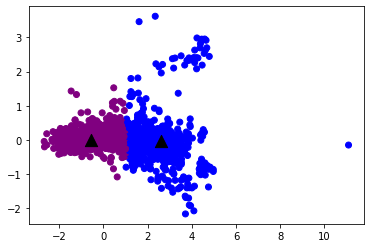

In [59]:
label1 = ["#0000FF", "#800080"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [69]:
drug_disease_sentences[drug_disease_sentences['outlier_flag'] == 0].describe(include='all')

,disease,drug,sentences,distance,outlier_flag
count,742,742,742,742.000000,742.0
unique,116,330,141,NaN,NaN
top,fibromyalgia,Clevidipine,"Immunodeficiency Syndrome"" OR meningitis OR ""s...",NaN,NaN
freq,69,10,290,NaN,NaN
mean,NaN,NaN,NaN,148.684636,0.0
std,NaN,NaN,NaN,117.165732,0.0
min,NaN,NaN,NaN,-1.000000,0.0
25%,NaN,NaN,NaN,50.000000,0.0
50%,NaN,NaN,NaN,130.000000,0.0
75%,NaN,NaN,NaN,209.000000,0.0
